**Target:**

Add Regularization, BatchNorm and dropout to improve model efficiency
Add global average pooling and remove big 7x7 kernel, adjust model parameters to be close to 7k

**Results:**

Parameters: 7k

Best Train Accuracy: 99.06

Best Test Accuracy: 99.31

**Analysis:**
Accuracy has not suffered in spite of reducing parameters with GAP
Could increase model capacity
No over-fitting, model is capable if pushed further

# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

from model import Net_2

/home/sn/anaconda3/envs/fastai2022/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.


In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

/home/sn/anaconda3/envs/fastai2022/lib/python3.9/site-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


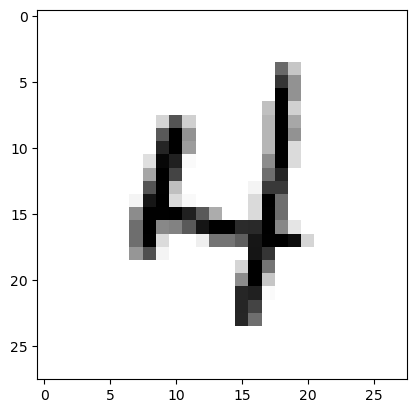

In [5]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.__next__()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

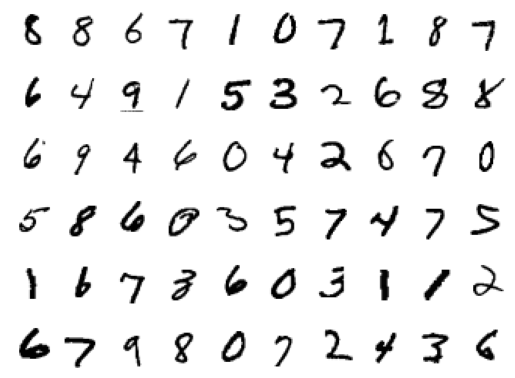

In [6]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's use the model Net_2 we imported from model.py file

# Model Params
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [7]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net_2().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
           Dropout-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 20, 24, 24]           1,800
              ReLU-6           [-1, 20, 24, 24]               0
       BatchNorm2d-7           [-1, 20, 24, 24]              40
           Dropout-8           [-1, 20, 24, 24]               0
            Conv2d-9           [-1, 10, 22, 22]           1,800
             ReLU-10           [-1, 10, 22, 22]               0
      BatchNorm2d-11           [-1, 10, 22, 22]              20
          Dropout-12           [-1, 10, 22, 22]               0
        MaxPool2d-13           [-1, 10, 11, 11]               0
           Conv2d-14           [-1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

In [8]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [9]:
model =  Net_2().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.13490480184555054 Batch_id=468 Accuracy=81.52: 100%|█| 469/469 [00:03<00:



Test set: Average loss: 0.1649, Accuracy: 9573/10000 (95.73%)

EPOCH: 1


Loss=0.06598719209432602 Batch_id=468 Accuracy=97.15: 100%|█| 469/469 [00:03<00:



Test set: Average loss: 0.0784, Accuracy: 9794/10000 (97.94%)

EPOCH: 2


Loss=0.11767805367708206 Batch_id=468 Accuracy=97.84: 100%|█| 469/469 [00:03<00:



Test set: Average loss: 0.0580, Accuracy: 9831/10000 (98.31%)

EPOCH: 3


Loss=0.042948950082063675 Batch_id=468 Accuracy=98.22: 100%|█| 469/469 [00:03<00



Test set: Average loss: 0.0450, Accuracy: 9867/10000 (98.67%)

EPOCH: 4


Loss=0.12060466408729553 Batch_id=468 Accuracy=98.35: 100%|█| 469/469 [00:03<00:



Test set: Average loss: 0.0406, Accuracy: 9876/10000 (98.76%)

EPOCH: 5


Loss=0.08224139362573624 Batch_id=468 Accuracy=98.53: 100%|█| 469/469 [00:03<00:



Test set: Average loss: 0.0396, Accuracy: 9894/10000 (98.94%)

EPOCH: 6


Loss=0.06651940196752548 Batch_id=468 Accuracy=98.67: 100%|█| 469/469 [00:03<00:



Test set: Average loss: 0.0392, Accuracy: 9888/10000 (98.88%)

EPOCH: 7


Loss=0.0508149117231369 Batch_id=468 Accuracy=98.77: 100%|█| 469/469 [00:03<00:0



Test set: Average loss: 0.0362, Accuracy: 9899/10000 (98.99%)

EPOCH: 8


Loss=0.020189838483929634 Batch_id=468 Accuracy=98.86: 100%|█| 469/469 [00:03<00



Test set: Average loss: 0.0303, Accuracy: 9909/10000 (99.09%)

EPOCH: 9


Loss=0.011100090108811855 Batch_id=468 Accuracy=98.96: 100%|█| 469/469 [00:03<00



Test set: Average loss: 0.0330, Accuracy: 9910/10000 (99.10%)

EPOCH: 10


Loss=0.03144941106438637 Batch_id=468 Accuracy=98.95: 100%|█| 469/469 [00:03<00:



Test set: Average loss: 0.0337, Accuracy: 9901/10000 (99.01%)

EPOCH: 11


Loss=0.020631466060876846 Batch_id=468 Accuracy=98.97: 100%|█| 469/469 [00:03<00



Test set: Average loss: 0.0309, Accuracy: 9903/10000 (99.03%)

EPOCH: 12


Loss=0.010319391265511513 Batch_id=468 Accuracy=99.00: 100%|█| 469/469 [00:03<00



Test set: Average loss: 0.0285, Accuracy: 9916/10000 (99.16%)

EPOCH: 13


Loss=0.09116416424512863 Batch_id=468 Accuracy=99.06: 100%|█| 469/469 [00:03<00:



Test set: Average loss: 0.0290, Accuracy: 9911/10000 (99.11%)

EPOCH: 14


Loss=0.018887056037783623 Batch_id=468 Accuracy=99.06: 100%|█| 469/469 [00:03<00



Test set: Average loss: 0.0265, Accuracy: 9931/10000 (99.31%)



Text(0.5, 1.0, 'Test Accuracy')

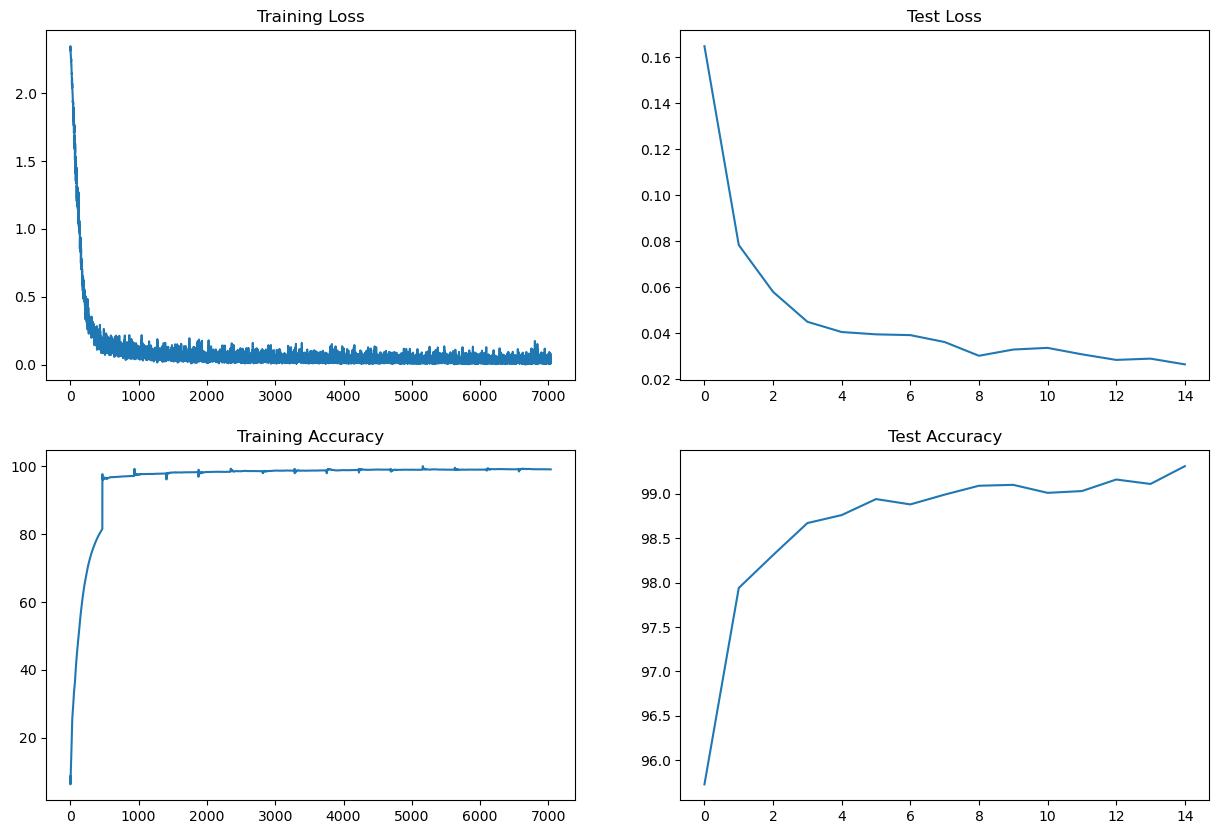

In [11]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")